In [36]:
from sympy import symbols, apart, factor

# Define the symbol
x = symbols('x')

# Define the rational function
expr = (x + 1) / (x**2 + 1)

# Factor the denominator
denominator_factors = factor(expr.as_numer_denom()[1])

# Convert the factors to real polynomials
real_factors = []
for factor in denominator_factors.args:
    if factor.is_real:
        real_factors.append(factor)
    else:
        real_factors.append(factor * factor.conjugate())

# Create the partial fraction decomposition with real factors
real_pfd = apart(expr, x, full=True, extension=True)

print(real_pfd)

RootSum(_w**2 + 1, Lambda(_a, (1/2 - _a/2)/(-_a + x)))


In [45]:
# Define polynomials P and Q
Numerator = np.poly1d([1,1,1])  # P(x) = x^2+x+1
Denominator = np.poly1d([1, 0, 2, 0, 1])  # Q(x) = x^4 + 2x^2 + 1

f: 0.0 1.0 1.0 -1.0 -2.0 1.0 3.0 -1.0 -4.0 1.0 5.0 -1.0 -6.0 1.0 7.0 -1.0 -8.0 1.0 9.0 -1.0 -10.0 1.0 11.0 -0.9999999999999 -12.0 1.0 13.0 -1.0 -14.0 1.0000000000001 15.0 -0.9999999999999 -16.0 0.9999999999999 17.0 -1.0 -18.0 1.0000000000001 19.0 -0.9999999999998
g: 0.0 1.0 1.0 -1.0 -2.0 1.0 3.0 -1.0 -4.0 1.0 5.0 -1.0 -6.0 1.0 7.0 -1.0 -8.0 1.0 9.0 -1.0 -10.0 1.0 11.0 -1.0 -12.0 1.0 13.0 -1.0 -14.0 0.9999999999999 15.0 -0.9999999999999 -16.0 1.0 17.0 -1.0 -18.0 0.9999999999999 19.0 -0.9999999999999
h: 0.0 0.0 1.0 1.0 -1.0 -2.0 1.0 3.0 -1.0 -4.0 1.0 5.0 -1.0 -6.0 1.0 7.0 -1.0 -8.0 1.0 9.0 -1.0 -10.0 1.0 11.0 -1.0 -12.0 1.0 13.0 -1.0 -14.0 1.0 15.0 -1.0 -16.0 1.0 17.0 -1.0 -18.0 1.0 19.0 -1.0


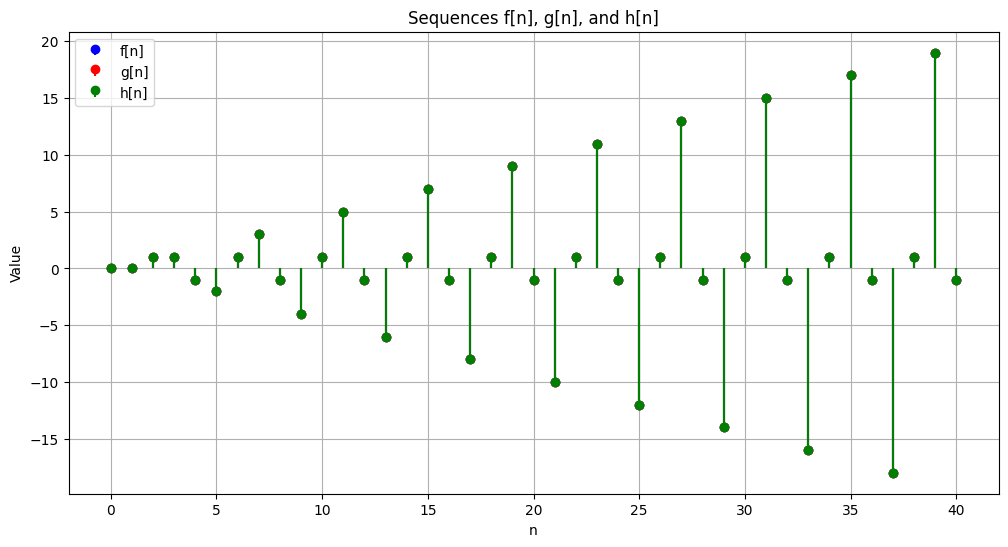

In [46]:
import math
import numpy as np
from scipy.signal import residue
from scipy.special import comb, factorial
from sympy import apart, sqrt, symbols, I, Poly, degree, arg
from collections import Counter
import matplotlib.pyplot as plt
# import ipdb

def real_PFD(expr):  # PFD = partial fraction decomposition
    result = apart(expr)
    # Extract coefficients, poles and their properties
    terms = result.as_ordered_terms()
    c, q, r = [], [], []
    for term in terms:
        numer_expr, denom = term.as_numer_denom()
        
        # Extract coefficient of numerator
        numer = Poly(numer_expr, x)
        numer_coeffs = numer.all_coeffs()
        if len(numer_coeffs) == 1:
            numer_coeffs.insert(0, 0)
        # Ensure all coefficients are evaluated to floats
        c.append([float(coeff.evalf()) if hasattr(coeff, 'evalf') else float(coeff) for coeff in numer_coeffs])
        
        # Extract power of the pole and poles
        denom_poly = Poly(denom, x)
        denom_factors = denom_poly.factor_list()[1]
        
        for factor, multiplicity in denom_factors:
            factor_expr = factor.as_expr()
            if degree(factor) == 1:
                # Real pole of the form (x - a)
                a = factor_expr.coeff(x, 1)
                pole = -factor_expr.coeff(x, 0) / a
                q.append(multiplicity)
                r.append(float(pole.evalf()) if hasattr(pole, 'evalf') else float(pole))  # Evaluate to float
            elif degree(factor) == 2:
                # Quadratic factor of the form (x^2 + ax + b)
                a = factor_expr.coeff(x, 1)
                b = factor_expr.coeff(x, 0)
                discriminant = a**2 - 4*b
                if discriminant < 0:
                    # Complex conjugate poles
                    pole1 = (-a + sqrt(discriminant)) / 2
                    pole2 = (-a - sqrt(discriminant)) / 2
                    q.append(multiplicity)
                    r.append(complex(pole1.evalf()) if hasattr(pole1, 'evalf') else complex(pole1))  # Evaluate to complex
                    r.append(complex(pole2.evalf()) if hasattr(pole2, 'evalf') else complex(pole2))  # Evaluate to complex
    return c, q, r

def compute_derivative(poly, order, z):
    poly = np.poly1d(poly)
    for _ in range(order):
        poly = np.polyder(poly)
    return poly(z)

def Juric_inverse_Z(P, Q, poles, multiplicities, n_values):
    K = len(poles)
    c = np.zeros((K, max(multiplicities)), dtype=complex)
    h_n = np.zeros(n_values, dtype=complex)
    
    for k in range(K):
        z_k = poles[k]
        m_k = multiplicities[k]
        
        # Create Q_k by dividing Q by (z - z_k)**m_k
        Q_k = np.polydiv(Q, np.poly1d([1, -z_k])**m_k)[0]
        
        for i in range(m_k):
            sum_term = 0
            for l in range(i):
                i_l = factorial(i) // factorial(i - l)
                sum_term += c[k, l] * i_l * compute_derivative(Q_k, i, z_k)
            c[k, i] = (compute_derivative(P, i, z_k) - sum_term) / (factorial(i) * np.polyval(Q_k, z_k))
    
    for n in range(n_values):
        for k in range(K):
            z_k = poles[k]
            m_k = multiplicities[k]
            for i in range(m_k):
                if z_k == 0:
                    if n == i:
                        h_n[n] += c[k, m_k - 1 - i]
                else:
                    h_n[n] += c[k, m_k - 1 - i] * comb(n, i) * (z_k ** (n - i))
    return h_n.real

def Moreira_Inverse_Z(Ac, rc, q):  # Ac*z/(z-rc)
    A, phi = np.abs(Ac), np.angle(Ac)  # Ac = A*exp(i*phi)
    r, theta = np.abs(rc), np.angle(rc)  # rc = r*exp(i*theta)

    if int(q) < q or q < 1:
        raise ValueError('q is a positive integer number.')
    if (theta in {0, np.pi}) and not (phi in {0, np.pi}):
        raise ValueError('if rc is real number, Ac must be real too.')

    def coef(n):
        if r == 0:  # Single/multiple poles at z = 0
            return A if n == (q-1) else 0
        else:  # Single/Multiple Real/Complex Poles except zero
            return 2 * A * (r**(n-q+1)) * comb(n, q-1) * np.cos((n-q+1)*theta + phi)

    return coef

def Our_Inverse_Z(q, A0, r_R, A1=None, r_I=None):
    r, theta = r_R, 0
    if r_I:
        root = r_R + 1j * r_I
        r, theta = np.abs(root), np.angle(root)
    
    def coef(n):
        if r_I:
            j = np.arange(q)
            S0 = (((-1)**j) * comb(n-1, j) * comb(n-(q+1+j), q-1-j) * np.sin((n-2*j-1)*theta)).sum()
            P0 = ((-1/4)**(q-1)) * (r**(n-2*q)) * (np.sin(theta))**(-2*q+1)
            S1 = (((-1)**j) * comb(n, j) * comb(n-(q+j), q-1-j) * np.sin((n-2*j)*theta)).sum()
            P1 = ((-1/4)**(q-1)) * (r**(n+1-2*q)) * (np.sin(theta))**(-2*q+1)
            return A0 * S0 * P0 + (A1 * S1 * P1 if A1 is not None else 0)
    
    return coef

n_values = 41  # Define your range of 'n'

# Initialize sequences
f = np.zeros(n_values)
g = np.zeros(n_values)

# Define polynomials P and Q
P = Numerator
Q = Denominator
z = np.poly1d([1, 0])  # z

# Convert P and Q to sympy polynomials
x = symbols('x')
P_sympy = sum(coeff * x**i for i, coeff in enumerate(P.coefficients[::-1]))
Q_sympy = sum(coeff * x**i for i, coeff in enumerate(Q.coefficients[::-1]))
fraction = P_sympy / Q_sympy  # Form the fraction P/Q
c, q, r = real_PFD(fraction)
for n in range(1, n_values):
    Our_sum = 0
    for i in range(len(c)):
      r_val = r[i]
      if r_val == I:
          r_val = 1j
      elif r_val == -I:
          r_val = -1j
      if isinstance(r_val, complex):
          r_R, r_I = r_val.real, r_val.imag
      else:
          r_R, r_I = float(r_val), 0
      Our_sum += Our_Inverse_Z(q=q[i], A0=c[i][1], A1=c[i][0], r_R=r_R, r_I=r_I)(n)
    g[n] = np.round(Our_sum, 13)

# Multiply Q by z
Q = np.polymul(Q, z)  # Q(z) = z(z^2 + 1)^2

# Get the coefficients of the polynomials
p_coeffs = P.c
q_coeffs = Q.c

# Use scipy.signal.residue to decompose the expression
r, p, k = residue(p_coeffs, q_coeffs)
r = np.round(r, 2)
p = np.round(p, 2)
k = np.round(k, 2)

# Count the multiplicities of the poles
multiplicities = Counter(p)

# Calculate f[n]
for n in range(1, n_values):
    Moreira_sum = 0
    first_idx = 0
    last_idx = 0
    seen_poles = {}
    for pole in multiplicities.keys():
        conjugate = pole.conjugate()
        if not conjugate in seen_poles:
            # Find indices of residues corresponding to the current pole
            q = multiplicities[pole]
            first_idx = last_idx
            last_idx = last_idx + q
            for idx in range(first_idx, last_idx):
                Ac = r[idx]
                rc = p[idx]
                Moreira_sum += Moreira_Inverse_Z(Ac, rc, idx-first_idx+1)(n)
        seen_poles[pole] = True
    f[n] = np.round(Moreira_sum, 13)

# Define poles and their multiplicities
poles = list(multiplicities.keys())
multiplicities = list(multiplicities.values())
h = Juric_inverse_Z(P, Q, poles, multiplicities, n_values)

print('f:', *f[1:])
print('g:', *g[1:])
print('h:', *h)
# Plot sequences f[n], g[n], and h[n]
plt.figure(figsize=(12, 6))
plt.stem(range(n_values), f, linefmt='b', markerfmt='bo', basefmt=" ", label='f[n]')
plt.stem(range(n_values), g, linefmt='r', markerfmt='ro', basefmt=" ", label='g[n]')
plt.stem(range(n_values), h, linefmt='g', markerfmt='go', basefmt=" ", label='h[n]')
plt.title('Sequences f[n], g[n], and h[n]')
plt.xlabel('n')
plt.grid(which='both')
plt.ylabel('Value')
plt.legend()
plt.show()